In [1]:
#-*- coding: utf-8 -*-

In [11]:
from IPython.display import Image

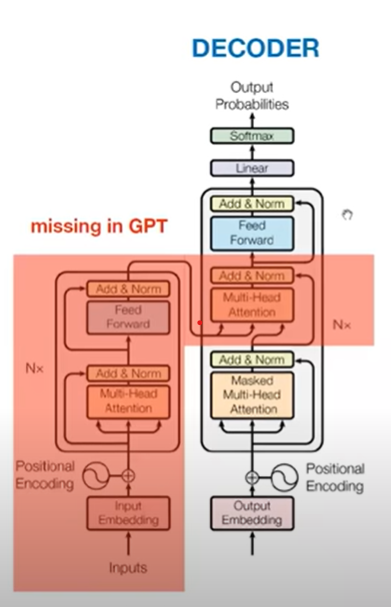

In [12]:
Image('/content/drive/MyDrive/трансформер своими лапками/Encoder-only.png', width = 300)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time

torch.manual_seed(42)

batch_size = 32 # кол-во независимых последовательностей текста, которые будут обрабатываться параллельно
block_size = 32 # длина каждой последовательности chunks
max_iters = 5000 #5000 # кол-во тренировочных итераций
eval_interval = 500
eval_iters = 200
learning_rate = 0.001
n_emb=36 # кол-во эмбеддингов
n_layer = 6 # кол-во слоев
n_head = 6 # кол-во голов внимания
head_size = n_emb // n_head # размер головы внимания

dropout = 0.2 # стандартный уровень
device = 'cuda' if torch.cuda.is_available() else 'cpu'



### Tiny-GPT

In [ ]:
# Обучать будем на тексте роман в стихах "Евгений Онегин"
with open('/content/drive/MyDrive/трансформер своими лапками/input_Onegin.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

In [ ]:
# мэппинг от букв к числам
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder преобразует строку в список чисел
decode = lambda l: ''.join([itos[i] for i in l]) # decoder преобразует список чисел в строку

In [ ]:
# таким образом кодируем каждый символ в число, а затем -  в тензоры
data = torch.tensor(encode(text), dtype = torch.long)

In [ ]:
# разбиваем список тензоров на тренировочную и валидационную выборки
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

In [14]:
def get_batch(split):
  """ функция генерации партии"""

  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i + block_size] for i in ix])
  y = torch.stack([data[i+1:i + block_size+1] for i in ix])
  x,y = x.to(device), y.to(device) # у,х - В*Т целочисленные тензоры
  return x,y

In [ ]:
@torch.no_grad()
def estimate_loss():
  """
  функция расчета потерь,
  будем вызывать при обучении

  """
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for z in range(eval_iters):
      xb, yb = get_batch(split)
      logits, loss = model(xb, yb)
      losses[z] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out



In [ ]:
class Head(nn.Module):
  """
    Голова слоя самовнимания
  """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_emb, head_size, bias = False)
    self.query = nn.Linear(n_emb, head_size, bias = False)
    self.value = nn.Linear(n_emb, head_size, bias = False)
    # tril это нижний треугольник матрицы,это не параметр модели =>
    # добавляем в данный модуль register_buffer
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)
    # расчет score внимания
    # (B, T, C) @ (B, C, T) -> (B, T, T)
    wei = q @ k.transpose(-2, -1)*k.shape[-1]**-0.5 # для нормализации
    # Tril matrix используется для маскирования следующего токена =>
    # так декодер учится предсказывать следующее слово
    wei = wei.masked_fill(self.tril[:T, :T] ==0, float('-inf'))
    wei = F.softmax(wei, dim = -1)
    wei = self.dropout(wei)
    v = self.value(x)
    out = wei @ v # (B,T,T) @ (B,T,C) ---> (B,T,C)

    return out

In [ ]:
class MultiHeadAttention(nn.Module):
  """
    Многоголовое внимание
  """

  def __init__(self, n_head, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
    self.proj = nn.Linear(n_head*head_size, n_emb)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim =-1)
    out = self.dropout(self.proj(out))
    return out


In [ ]:
class FeedForward(nn.Module):
  """
  Линейный слой следующий за ReLu
  """

  def __init__(self, n_emb):
    super().__init__()
    # в статье Attention is All You Need paper
    # используется ffwd layer 2048 и выход модели равен 512
    # по аналогии применим фактор, равный 4
    self.net = nn.Sequential(
        nn.Linear(n_emb, 4*n_emb),
        nn.ReLU(),
        nn.Linear(n_emb*4, n_emb),
        nn.Dropout(dropout),
         )


  def forward(self, x):
    return self.net(x)

In [ ]:
class Block(nn.Module):
  """
  Данный класс объединяет Многоголовое внимание и
  FeedForward NN
  """

  def __init__(self, n_emb, n_head):
    super().__init__()
    head_size = n_emb//n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffd = FeedForward(n_emb)
    # слой нормализации
    self.ln1 = nn.LayerNorm(n_emb)
    self.ln2 = nn.LayerNorm(n_emb)

  def forward(self, x):
    # "x +" помогает в оптимизации
    # также мы применяем слой нормализации до самовнимания
    # и перед feed-forward (в этом перестановка в отличие от
    # архитектуры, описанной в оригинальной статье)
    x = x+ self.sa(self.ln1(x))
    x = x+ self.ffd(self.ln2(x))

    return x

In [ ]:
class LanguageModel(nn.Module):
  """ Собственно GPT- модуль """

  def __init__(self):
    super().__init__()
    # каждый токен считывает the logits для следующего токена из таблицы
    self.token_embedding_table = nn.Embedding(vocab_size, n_emb)
    #на каждая позиция от 0 до block_size-1 будет ее эмбеддинг
    self.position_embedding_table = nn.Embedding(vocab_size, n_emb)
    self.blocks = nn.Sequential(*[Block(n_emb, n_head = n_head) for _ in range(n_layer)])
    # слой нормализации добавляем до линейного слоя
    self.ln_f = nn.LayerNorm(n_emb)
    self.lm_head = nn.Linear(n_emb, vocab_size)
    self.apply(self._init_weights)

  def _init_weights(self, module):
    # задаем изначальные веса
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean =0.0, std = 0.2)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)
    if isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean =0.0, std = 0.2)


  def forward(self, idx, targets=None):
    B,T = idx.shape
    # idx и targets - это (B,T) тензор целых чисел
    # the tok_emb is (B, T, C), C = NUM_EMBED
    tok_emb = self.token_embedding_table(idx)
    # (T, C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device))
    x = tok_emb+pos_emb
    # применяем одну голову само-внимания
    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x) #B,T,vocab_size

    # расчет функции потерь
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      # меняем размерность матриц для входных данных
      # в функцию кросс-энтропии
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx - это (B, T) массив индексов в текущем контексте
    for _ in range(max_new_tokens):
      # обрезаем конекст до последнего токена в block_size
      # т.к. токены не "общаются" между блоками
      idx_cond = idx[:, -block_size:]
      # получаем предсказание
      logits, loss = self.forward(idx_cond)
      logits = logits[:, -1, :] #становятся B, C
      # применяем softmax, чтобы получить вероятности
      probs = F.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples = 1) # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

In [ ]:
# задаем модель и задаем оптимизатор
# также не забываем применить torch.compile() для ускорения
model = LanguageModel()
m = model.to(device)
opt_m = torch.compile(m)
# AdamW - широко используемый оптимизатор для трансформеров
optimizer = torch.optim.AdamW(opt_m.parameters(), learning_rate)

In [ ]:
# посмотрим размеры нашей маленькой GPT-модели
print(sum(p.numel() for p in opt_m.parameters())/1e6, "M params")

0.111567 M params


In [ ]:
%%time
# cобственно процесс обучения, который занял чуть меньше 5ти минут
# на видео-карте Т4, доступной на Google Colab, а также
# при использовании torch.compile() - новой функции ускорения из Pytorch 2.0
for iter in range(max_iters):
  if iter%eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    print(f"step {iter}: train loss{losses['train']: .4f}, val_loss {losses['val']: .4f}")
  xb, yb = get_batch('train')
  logits, loss = opt_m(xb, yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()


step 0: train loss 5.7217, val_loss  5.6468


[2023-06-14 10:37:24,557] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


step 500: train loss 2.7592, val_loss  3.1791
step 1000: train loss 2.6476, val_loss  2.9628
step 1500: train loss 2.5738, val_loss  2.9174
step 2000: train loss 2.5107, val_loss  2.8786
step 2500: train loss 2.4649, val_loss  2.8158
step 3000: train loss 2.4223, val_loss  2.7844
step 3500: train loss 2.3770, val_loss  2.7509
step 4000: train loss 2.3504, val_loss  2.7414
step 4500: train loss 2.3134, val_loss  2.7111
step 4999: train loss 2.2895, val_loss  2.7180
CPU times: user 3min 48s, sys: 5.33 s, total: 3min 54s
Wall time: 4min 40s


### Теперь посмотрим, что получилось: ниже 2 примера генерации

In [ ]:
print(decode(opt_m.generate(idx = torch.zeros((1, 1), dtype = torch.long, device=device), max_new_tokens = 500)[0].tolist()))



Не бесты, каковой Ба и твов кобень.
Абщам? Гесисто, Онегий тень!.
И пряда, «Кактьейди менцу;
Пожа, петуль любиница, зне толы»[34]а;
Чкость посто нейдива!.
К Ошим сво Евых, –от ттом ы Жекры;
И езу лекяю наститы,
Пой чтой (го, прейков что отой сье
2] потот исковотестны,
Уловетал кепренсялиго чивещду,
Не лобоскний жато дулез.
Мим поль и муя ариску дор,
Ув, потцатальцо стет,
И себесты вутсмекою в нодит;
Оуриновнысь мрилланье уда
И тотрукикой вынетья! – ругой,
Оной мдерезкий вастераной
Мымь вню тлюм


In [ ]:
print(decode(opt_m.generate(idx = torch.zeros((1, 1), dtype = torch.long, device=device), max_new_tokens = 2000)[0].tolist()))



Не бостым касовой Ба и,
О в кобрам. крабм м ве стомошый.
Тдоздой у идаяй нь наше мадим.
Илельск. оленту
И люнинирани ве тость[e» Ной сте[a]
Рах «Езвдев гдра Ишимы Тровных,
Кот итна ыдорамыхоби ку лакязр,
Почивезнни а кое! в,
Дре ков чтцноцой сьжируме тья пь оботест,
Тозореги г кепртной иго чивездура.
Дло, скам) жный дулезака, (покохи стя арит
К дораждв, ав цета…
Н сутетры стой, дый у моролю
Чпек.I
Голириной ист м сьланобижда
Обыбарек порья нежуж лакруго
Би волим чнезот
Двастераной гомь вню влеме с счкиховтошшо:
Ота и трай, пачидда, босте нелогры;
Брндле нресато.
«Гох преблат кь вей тостям иж нот
И Молнатесаетв яашечи.

Чкоте пого гатковвод. ващу, перовыво по дя,
Пожитнскологита гнм
Етха вресё в довори пепокой.
Кял ежер л в.
XILI
В, не перанчераксти, нешькаю н в зпе сларей,
Мупыней одышимо, пд
Еную скл нь свочечя!
Ку? воник 
Яk стесл прижчлJдедедь;».
Да, х кпрретынаюlk Слрава-ен очо
Бномужчад… г за Бра.
do чтокесь вутя, А лерез посм.

Ны м боэемы дую пуе норе сть
С пр кнегу шадра Еур,

In [ ]:
#
import os
from datetime import datetime
def save_model_to_chekpoint(
    model: torch.nn.Module, path_to_checkpoint: str = "checkpoints", epoch: int = 0
):
    # check if path exists, otherwise create it
    if not os.path.exists(path_to_checkpoint):
        os.makedirs(path_to_checkpoint)

    # datetime object containing current date and time
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d.%m.%Y_%H:%M:%S")
    checkpoint_name = "checkpoint_epoch-" + str(epoch) + "_" + dt_string + ".pt"
    full_path = os.path.join(path_to_checkpoint, checkpoint_name)
    try:
        torch.save(model.state_dict(), full_path)
        print("Successfully saved the model to {}".format(full_path))
    except Exception as e:
        print(f"Error saving the model to checkpoint. {e}")

In [ ]:
save_model_to_chekpoint(opt_m, path_to_checkpoint="checkpoints", epoch=max_iters)

Successfully saved the model to checkpoints/checkpoint_epoch-5000_14.06.2023_08:21:38.pt
